# Week 10 - Introduction to Modeling

# 1. Lesson

Last week, we reviewed one model: linear regression.  This week, we are going to review another, called random forest.  The random forest model builds many decision trees, then averages their estimates to make a prediction.

You will also perform:
* Cross-validation
* Hyperparameter tuning
* A performance metric (root mean squared error)

### How does random forest work?

A random forest is a set of decision trees.  Let's say we use n_estimators = 100 decision trees, and we have ten features.  Then each decision tree is built so that a given branch gets about three (sqrt(10)) features to choose from.  It starts from the top of the tree, selects the best feature, then proceeds to the next nodes.  The best feature is the one that minimizes the mean squared error, which must be computed for both branches, weighted according to the probability of each branch, and then summed over both branches.

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

Here, we build three series of random numbers between 0 and 1.  We use a somewhat arbitrary formula to construct the synthetic data.  The fourth value (the target) equals the first series minus twice the second, with the whole then being multiplied by the third series.  If we stopped here, the target would be completely dependent on the three feature series - it would be easy to predict.  However, we then add a random normal distribution to make the prediction harder.

There are a train series and a test series, with different features ("a" and "b"), and with different random normal data added.  This tests whether our model can predict new data.  We fit to the "a" features using the train_target, then predict the test_target using the "b" features.

In [2]:
np.random.seed(0)
num_points = 10000
feature_1a = np.random.random(size = num_points) * 3
feature_2a = np.random.random(size = num_points) * 3
feature_3a = np.random.random(size = num_points) * 3
train_target = (feature_1a - 2 * feature_2a) * feature_3a + np.random.normal(size = num_points)
feature_1b = np.random.random(size = num_points) * 3
feature_2b = np.random.random(size = num_points) * 3
feature_3b = np.random.random(size = num_points) * 3
test_target = (feature_1b - 2 * feature_2b) * feature_3b + np.random.normal(size = num_points)
train_df = pd.DataFrame({"f1": feature_1a, "f2": feature_2a, "f3": feature_3a})
test_df = pd.DataFrame({"f1": feature_1b, "f2": feature_2b, "f3": feature_3b})
rf = RandomForestRegressor()
rf.fit(train_df.values, train_target)

RandomForestRegressor()

As expected, the RMSE is smallest when predicting the training data, larger when predicting the testing data, and largest when comparing random (shuffled) data instead of using a prediction.  In the last case, there is no attempt to make a good prediction.  The small RMSE when predicting the training data indicates that the model has "memorized" the training data to some degree.

In [3]:
print("RMSE when predicting training data:")
print(root_mean_squared_error(rf.predict(train_df.values), train_target))
print("RMSE when predicting testing data:")
print(root_mean_squared_error(rf.predict(test_df.values), test_target))
test_target_shuffle = test_target.copy()
np.random.shuffle(test_target_shuffle)
print("RMSE with random predictions:")
print(root_mean_squared_error(test_target_shuffle, test_target))

RMSE when predicting training data:
0.40439828823725865
RMSE when predicting testing data:
1.0667260022550893
RMSE with random predictions:
5.262103337484077


Next, we perform a Grid Search over various parameters.  We've used a small number of parameters here, but you could add more.  The first parameter, n_estimators, shows the number of decision trees in the random forest.  The second, max_depth, is the maximum depth of each tree.  By picking three n_estimators values (10, 33, 100) and three max_depth values (2, 4, None), we allow for nine parameter combinations.  For example, (n_estimators = 10, max_depth = 2) is a combination.  The grid search tries all nine combinations and uses cross validation to choose the best one.  This is done below.

### What is cross validation?

Cross validation is a way to find out which parameter combination is the best.  With 5-fold cross validation (the default) we divide the data into five equal-sized groups.  Four of them are used as training data and the fifth is testing data.  The score (in this case the root mean squared error) on the testing data is recorded.  This is done for each split: that is, each fifth is taken out and used as testing data; then, the five root mean squared errors (from taking out the five fifths, one at a time) are averaged.

We now have root mean squared error value for each parameter combination, allowing us to choose the best combination.

In [4]:
np.random.seed(0)
gcv = GridSearchCV(estimator = RandomForestRegressor(), param_grid = {"n_estimators": [10, 33, 100], "max_depth": [2, 4, None]}, \
                   scoring = "neg_root_mean_squared_error")
gcv.fit(train_df.values, train_target)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': [2, 4, None],
                         'n_estimators': [10, 33, 100]},
             scoring='neg_root_mean_squared_error')

In [5]:
print(gcv.best_estimator_)
print(gcv.best_params_)
print(gcv.best_score_)

RandomForestRegressor()
{'max_depth': None, 'n_estimators': 100}
-1.0851316531496098


In [6]:
gcv.cv_results_["mean_test_score"] # There are nine scores, one for each of the 3 x 3 hyperparameter combinations

array([-2.27296628, -2.26369708, -2.26370023, -1.56063403, -1.52732923,
       -1.52615891, -1.12271876, -1.09384603, -1.08513165])

### Why does n_estimators grow like 10, 33, 100 instead of like 1, 50, 100?

First of all, we can make it grow however we want.  The question is why we chose 10, 33, 100.  The idea here is that when you have no idea what is the appropriate number, you should pick guesses that grow exponentially.  For example, suppose you are trying to guess the height of a particular tree.  You look online and find that redwoods grow to 400 feet high, while bonsai trees may be as short as six inches.  If you get three guesses, you could guess: one foot, 200 feet, 400 feet.  These guesses would be linearly spaced out.  However, the 200 foot guess feels wrong - it's still very tall.  Most trees don't grow that tall.  Instead, let's make a geometric progression:

In [7]:
list(map(round, [400**0, 400**0.25, 400**0.5, 400**0.75, 400*1]))

[1, 4, 20, 89, 400]

Now the guesses are four feet, 20 feet, and 89 feet.  (We'll drop the initial 1 and the final 400.) That feels more plausible: the middle value, 20 feet, is representative of many actual trees in a way that the middle 200 foot guess wasn't.

# 2. Weekly graph question

In words, please summarize what this graph shows.

In [96]:
rmse_lst = list()
for x in range(round(num_points / 20), num_points, round(num_points / 20)):
    rf.fit(train_df.values[0:x,:], train_target[0:x])
    rmse_lst.append(root_mean_squared_error(rf.predict(test_df.values), test_target))

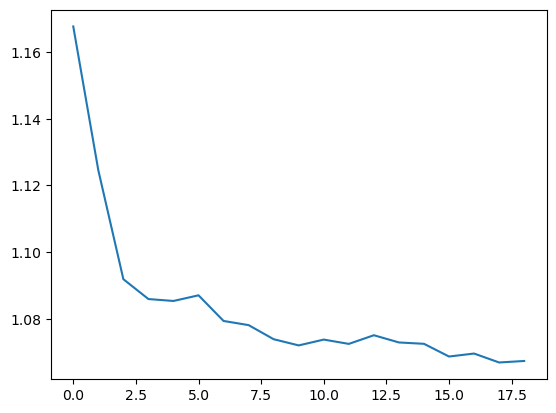

In [9]:
import matplotlib.pyplot as plt

plt.plot(rmse_lst)

### Summary of Graph
The code block iterates through slices of the dataset ranging from 500 training points to 10,000 training points by intervals of 500 and calculates the root mean squared error for the fitted model at each slice. This line plot shows the root mean squared error changing as more data is used to train the dataset. This is also known as a training loss curve and represents model performance improvement as the model is learning.

# 3. Homework

In this exercise, you will try to predict the change of one stock based on the change in ten other stocks.

In [10]:
def make_X_y(alpha = 0.5):
    df_hwk = pd.DataFrame()
    num_samples_hwk = 10000
    common_odd = np.random.normal(size = num_samples_hwk)
    common_even = np.random.normal(size = num_samples_hwk)
    common_three = np.random.normal(size = num_samples_hwk)
    for n in range(11):
        common = np.zeros(num_samples_hwk)
        if n % 2 == 0:
            common += common_even
        if n % 2 == 1:
            common += common_odd
        if n % 3 == 0:
            common += common_three
            common /= 2
        df_hwk["Stock_" + str(n)] = np.random.normal(size = num_samples_hwk) + alpha * common
    X = df_hwk.values[:,:-1]
    y = df_hwk.values[:,-1]
    return X, y

The above code creates an X with ten columns, corresponding to ten different stocks.  The y is the eleventh stock.  The stocks have some commonalities: the even numbered stocks are related, as are the odds.  The stocks that are multiples of three are all related, too.  Random forest should be able to sort through all this and decide that the eleventh stock is related to the odd numbered, non-divisible-by-three stocks, and predict accordingly.  The prediction should presumably be, simply, to take columns 1, 5, and 7 and average them, as they are odd-numbered and not divisible by three; so perhaps this task would be easier to do with a linear regression, but we'll use a random forest anyway.  The value "alpha" determines how important the common element is.  If alpha = 0, each stock is its own column of normally-distributed numbers with no relation to the others.  If alpha = 10, then the great majority of the variation in the stock values comes from the common elements.

### Question: 

Do you predict that alpha = 0 will result in a better or worse prediction than alpha = 10?  Remember that the prediction must be performed on test data, so you'll need an X_train and y_train for training and a separate X_test and y_test for testing.  I recommend using a correlation rather than a MSE or RMSE in this case, if you want to directly compare two different predictions, because the MSE and RMSE vary with the magnitude of the data as well as with the quality of the prediction.

After you make the prediction, try it out, and comment on what you learned.

### Randomized Search

Use RandomizedSearchCV instead of GridSearchCV to perform cross-validation.

### Scoring

Research the scoring parameters under "regression":

https://scikit-learn.org/dev/modules/model_evaluation.html#scoring-parameter

Choose at least one that you want to learn about, use it, and research it online.  Write something about what you've learned about it.

In [11]:
# Imports
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy.stats import pearsonr

## My Prediction
I predict that an alpha of 10 will produce a better prediction because alpha determines how important the common element is meaning that the higher the alpha the more correlated the features will be. A low alpha will result in 11 columns with little to no relationship making it nearly impossible to make a good prediction.

### Case 1: alpha = 0

In [12]:
# Make data
X1, y1 = make_X_y(alpha=0)

# Train, test, split
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

# Creating  Model
rf_model1 = RandomForestRegressor(random_state=42)
rf_model1.fit(X1_train, y1_train)

RandomForestRegressor(random_state=42)

In [13]:
train_ypreds1 = rf_model1.predict(X1_train)
test_ypreds1 = rf_model1.predict(X1_test)

print("Correlations when predicting training data:")
print(pearsonr(y1_train, train_ypreds1))

print("\nCorrelations when predicting testing data:")
print(pearsonr(y1_test, test_ypreds1))

Correlations when predicting training data:
PearsonRResult(statistic=0.9892816077802651, pvalue=0.0)

Correlations when predicting testing data:
PearsonRResult(statistic=0.043783216567316985, pvalue=0.05025822262394556)


### Case 2: alpha = 10

In [14]:
# Make data
X2, y2 = make_X_y(alpha=10)

# Train, test, split
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

# Creating  Model
rf_model2 = RandomForestRegressor(random_state=42)
rf_model2.fit(X2_train, y2_train)

RandomForestRegressor(random_state=42)

In [15]:
train_ypreds2 = rf_model2.predict(X2_train)
test_ypreds2 = rf_model2.predict(X2_test)

print("Correlations when predicting training data:")
print(pearsonr(y2_train, train_ypreds2))

print("\nCorrelations when predicting testing data:")
print(pearsonr(y2_test, test_ypreds2))

Correlations when predicting training data:
PearsonRResult(statistic=0.9989803107616226, pvalue=0.0)

Correlations when predicting testing data:
PearsonRResult(statistic=0.9930589011677324, pvalue=0.0)


### Randomized CV Search for Case 1 (alpha=0)

In [81]:
# Define parameter grid
param_dist1 = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

def pearson_corr(y_true, y_pred):
    return pearsonr(y_true, y_pred)[0]

scorer = make_scorer(pearson_corr, greater_is_better=True)

# RandomizedSearchCV
rs1 = RandomizedSearchCV(
    estimator=rf_model1,
    param_distributions=param_dist1,
    cv=5,
    scoring=scorer,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit it
rs1.fit(X1_train, y1_train)

# Best model
best_rf1 = rs1.best_estimator_

# Predict
y1_pred = best_rf1.predict(X1_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [ ]:
print(f'Best Model Parameters: {rs1.best_params_}')
print(f'Best Training Score from Cross-Validation: {rs1.best_score_:.4f}') # Pearson Correlation Coefficient
print(f'Test Score from Best Model: {pearsonr(y1_test, y1_pred)[0]:.4f}') # Pearson Correlation Coefficient

Best Model Parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 30}
Best Training Score from Cross-Validation: 0.0062
Test Score from Best Model: 0.0040


### Randomized CV Search for Case 2 (alpha=10)

In [83]:
# Define parameter grid
param_dist2 = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# RandomizedSearchCV
rs2 = RandomizedSearchCV(
    estimator=rf_model2,
    param_distributions=param_dist2,
    cv=5,
    scoring=scorer,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit it
rs2.fit(X2_train, y2_train)

# Best model
best_rf2 = rs2.best_estimator_

# Predict
y2_pred = best_rf2.predict(X2_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [84]:
print(f'Best Model Parameters: {rs2.best_params_}')
print(f'Best Training Score from Cross-Validation: {rs2.best_score_:.4f}') # Pearson Correlation Coefficient
print(f'Test Score from Best Model: {pearsonr(y2_test, y2_pred)[0]:.4f}') # Pearson Correlation Coefficient

Best Model Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 10}
Best Training Score from Cross-Validation: 0.9930
Test Score from Best Model: 0.9933


From this analysis of the two datasets (alpha=0 and alpha=10), it appears that my prediction was correct. The model trained with data that is more dependent on the common element performed better. The 1st model trained with data made where alpha=0 showed a very low pearson correlation coefficient indicating that the features are not correlated in a linear manner. The 2nd model trained with data made where alpha=10 showed a very high pearson correlation coeffiecient indicating that the features are strongly correlated in a linear manner. After tuning, the models showed little improvements. One thing to note is that for the second model, the train score and test score are both high indicating good predicting performance.

### Scoring Parameter Research: neg_mean_absolute_percentage_error

In [90]:
from sklearn.metrics import mean_absolute_percentage_error

# Define parameter grid
param_dist3 = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# RandomizedSearchCV
rs3 = RandomizedSearchCV(
    estimator=rf_model2, # used best model, alpha = 10
    param_distributions=param_dist3,
    cv=5,
    scoring='neg_mean_absolute_percentage_error',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit it
rs3.fit(X2_train, y2_train)

# Best model
best_rf3 = rs3.best_estimator_

# Predict
y3_pred = best_rf3.predict(X2_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [91]:
print(f'Best Model Parameters: {rs3.best_params_}')
print(f'Best Training Score from Cross-Validation (MAPE): {-rs3.best_score_:.4f}') # Mean absolute percentage error
print(f'Test Score from Best Model (MAPE): {mean_absolute_percentage_error(y2_test, y3_pred):.4f}') # Mean absolute percentage error

Best Model Parameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}
Best Training Score from Cross-Validation (MAPE): 0.7277
Test Score from Best Model (MAPE): 0.5654


I chose to try out the neg_mean_absolute_percentatge_error scoring parameter because this parameter is also scale independent making it possible to compare different models. Working with percentages instead of units of the data set makes the computation simpiler and easier to interpret. Due to the nature of how percentages are calculated, larger errors may be looked over and smaller errors may appear more relevant. 

# 4. Storytelling With Data plot

Reproduce any graph of your choice in chapter six (p. 151-163) of the Storytelling With Data book as best you can. You do not have to get the exact data values right, just the overall look and feel.

In [ ]:
# -------------------------------
# Recreation of graph from p. 152
# -------------------------------

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Define how many points to generate
num = 30

# Generate x-axis data
x1 = np.linspace(0, 30, num)
x2 = np.linspace(0, 10, num)

# Define y1 and y2
y1 = []
y2 = []

# Generate y-axis data with some noise
for point in range(0, num):
    point1 = np.random.randint(0, 51400) + np.random.randint(0, 5)
    point2 = np.random.randint(0, 33967) + np.random.randint(0, 5)
    y1.append(point1)
    y2.append(point2)

# Sort to show positive trend
y1.sort()
y2.sort()

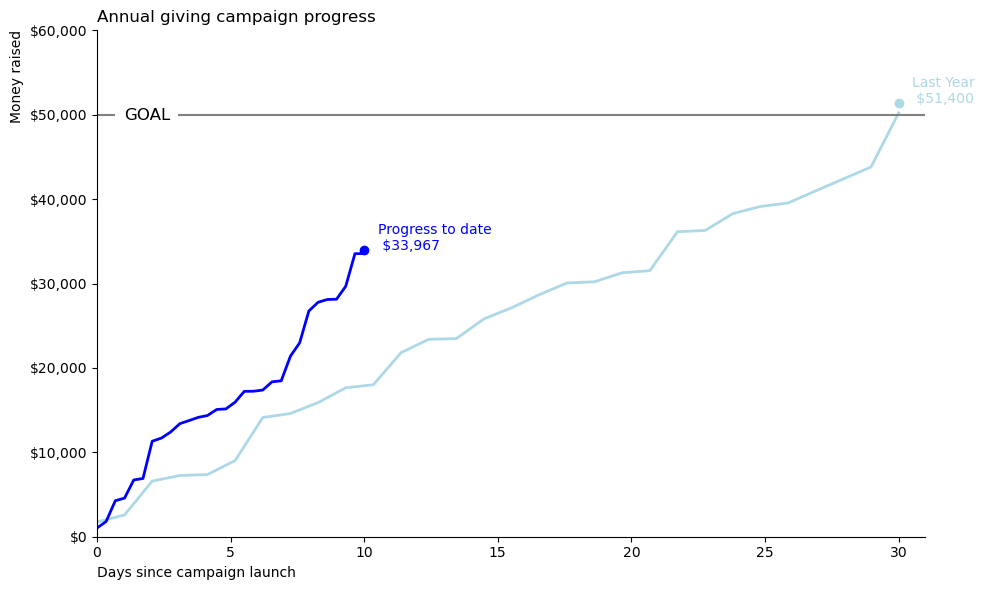

In [71]:
# Plot two lines
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(x1, y1, label='Line 1', linewidth=2, color='lightblue')
plt.plot(x2, y2, label='Line 2', linewidth=2, color='blue')
plt.ylim(0, 60000)
plt.xlim(0, 31)

# Plot end points
plt.scatter(30, 51400, color='lightblue')
plt.text(30.5, 51400, 'Last Year \n $51,400', color='lightblue')

plt.scatter(10, 33967, color='blue')
plt.text(10.5, 33967, 'Progress to date \n $33,967', color='blue')

# Plot goal line
plt.axhline(y=50000, color='gray')
plt.text(1, 49400, 'GOAL', fontsize=12, bbox=dict(facecolor='white', edgecolor='None', boxstyle='square,pad=0.5'))

# Dollar formatter function
def dollar_format(x, pos):
    return f'${x:,.0f}'

# Format y-axis as dollars
formatter = FuncFormatter(dollar_format)
plt.gca().yaxis.set_major_formatter(formatter)

# Remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add labels
plt.xlabel('Days since campaign launch', loc='left')
plt.ylabel('Money raised', loc='top')
plt.title('Annual giving campaign progress', loc='left')

# Format chart and display
plt.grid(False)
plt.tight_layout()
plt.show()